In [ ]:
from os.path import join, isdir
from os import listdir, rmdir
from shutil import move, rmtree, make_archive

import os
import cv2
import glob
import pickle
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

from tensorflow.keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Input, Dropout, Activation, Flatten, BatchNormalization, ReLU, LeakyReLU, concatenate
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, AveragePooling2D, GlobalAveragePooling2D, Add

from google.colab import drive
drive.mount('/gdrive')
drive_root = '/gdrive/My Drive/city'

COLAB_DIR = '/content/'
GT_DIR = COLAB_DIR + 'gtFine/gtFine/'
IMG_DIR = COLAB_DIR + 'leftImg/leftImg8bit/'

Mounted at /gdrive


In [ ]:
pip install cityscapesscripts

     |████████████████████████████████| 472 kB 5.1 MB/s 
     |████████████████████████████████| 78 kB 5.6 MB/s 
     |████████████████████████████████| 46 kB 2.7 MB/s 
     |████████████████████████████████| 86 kB 4.6 MB/s 
  Created wheel for typing: filename=typing-3.7.4.3-py3-none-any.whl size=26325 sha256=1d88c263a68c7806d49954354160fa66b7a230cb5f1e603ad3eb5c19d9eb3729
  Stored in directory: /root/.cache/pip/wheels/35/f3/15/01aa6571f0a72ee6ae7b827c1491c37a1f72d686fd22b43b0e
Successfully built typing


In [ ]:
from cityscapesscripts.download import downloader

# registration on https://www.cityscapes-dataset.com/
session = downloader.login()
downloader.get_available_packages(session=session)

# data for semantic segmentation task
print('Downloading gtFine and leftImg8bit packages ...\n')
package_list =['gtFine_trainvaltest.zip', 'leftImg8bit_trainvaltest.zip']
downloader.download_packages(session=session, package_names=package_list, destination_path=COLAB_DIR)

Cityscapes username or email address: sahruday@umd.edu
Cityscapes password: ··········
Store credentials unencrypted in '/root/.local/share/cityscapesscripts/credentials.json' [y/N]: y



In [ ]:
!unzip -q gtFine_trainvaltest.zip -d gtFine
!unzip -q leftImg8bit_trainvaltest.zip -d leftImg

In [ ]:
# collapse child directories
for parent in listdir(GT_DIR):
    parent_dir = GT_DIR + parent
    for child in listdir(parent_dir):
        if isdir(join(parent_dir, child)):
            keep = glob.glob(join(parent_dir, child) + '/*_gtFine_color.png')
            keep = [f.split('/')[-1] for f in keep]
            for filename in list(set(listdir(join(parent_dir, child))) & set(keep)):
                move(join(parent_dir, child, filename), join(parent_dir, filename))
            rmtree(join(parent_dir, child))

for parent in listdir(IMG_DIR):
    parent_dir = IMG_DIR + parent
    for child in listdir(parent_dir):
        if isdir(join(parent_dir, child)):
            for filename in listdir(join(parent_dir, child)):
                move(join(parent_dir, child, filename), join(parent_dir, filename))
            rmtree(join(parent_dir, child))

In [ ]:
IMG_SHAPE = 299, 299

gt_train_paths = [GT_DIR+'train/' + path for path in listdir(GT_DIR+'train/')]
gt_test_paths = [GT_DIR+'test/' + path for path in listdir(GT_DIR+'test/')]
gt_val_paths = [GT_DIR+'val/' + path for path in listdir(GT_DIR+'val/')]
gt_paths = gt_train_paths + gt_test_paths + gt_val_paths

im_train_paths = [IMG_DIR+'train/' + path for path in listdir(IMG_DIR+'train/')]
im_test_paths = [IMG_DIR+'test/' + path for path in listdir(IMG_DIR+'test/')]
im_val_paths = [IMG_DIR+'val/' + path for path in listdir(IMG_DIR+'val/')]
im_paths = im_train_paths + im_test_paths + im_val_paths

def resize_image(path):
    img = Image.open(path)
    img.thumbnail(IMG_SHAPE)
    out_file = join(path)
    img.save(out_file, 'PNG')

for img in gt_paths + im_paths:
    resize_image(img)

make_archive('gtFine', 'zip', GT_DIR)
make_archive('leftImg', 'zip', IMG_DIR)

'/content/leftImg.zip'

In [ ]:
def download_if_missing(url, target, extract=True):
    if os.path.exists(target):
        return target
    return tf.keras.utils.get_file(target, origin=url, extract=extract)

gt_url_file = 'https://storage.googleapis.com/mcg2208/gtFine.zip'
im_url_file = 'https://storage.googleapis.com/mcg2208/leftImg.zip'

gt_file, gt_dir = join(COLAB_DIR + 'gtFine.zip'), join(COLAB_DIR + 'gtFine/')
im_file, im_dir = join(COLAB_DIR + 'leftImg.zip'), join(COLAB_DIR + 'leftImg/')

download_if_missing(gt_url_file, gt_file, extract=False)
download_if_missing(im_url_file, im_file, extract=False)

!unzip -q $gt_file -d $gt_dir
!unzip -q $im_file -d $im_dir

In [ ]:
# normalize image pixels
IMG_SIZE = 299
BATCH_SIZE = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

GT_DIR = COLAB_DIR + 'gtFine/'
IMG_DIR = COLAB_DIR + 'leftImg/'

def load_and_preprocess_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img /= 255.0
    return img

def get_image_paths(dir):
    return sorted([dir + path for path in listdir(dir)])

# create tf.Dataset objects
gt_train_ds = tf.data.Dataset.from_tensor_slices(get_image_paths(GT_DIR+'train/'))
gt_val_ds = tf.data.Dataset.from_tensor_slices(get_image_paths(GT_DIR+'val/'))
gt_test_ds = tf.data.Dataset.from_tensor_slices(get_image_paths(GT_DIR+'test/'))

gt_train_ds = gt_train_ds.map(load_and_preprocess_image)
gt_val_ds = gt_val_ds.map(load_and_preprocess_image)
gt_test_ds = gt_test_ds.map(load_and_preprocess_image)

im_train_ds = tf.data.Dataset.from_tensor_slices(get_image_paths(IMG_DIR+'train/'))
im_val_ds = tf.data.Dataset.from_tensor_slices(get_image_paths(IMG_DIR+'val/'))
im_test_ds = tf.data.Dataset.from_tensor_slices(get_image_paths(IMG_DIR+'test/'))

im_train_ds = im_train_ds.map(load_and_preprocess_image)
im_val_ds = im_val_ds.map(load_and_preprocess_image)
im_test_ds = im_test_ds.map(load_and_preprocess_image)

In [ ]:
def visualize_images(img, gt, pred):
    if pred is not None:
        fig, axes = plt.subplots(1, 3, figsize=(12, 8))
    else:
        fig, axes = plt.subplots(1, 2, figsize=(8, 8))

    axes[0].imshow(img)
    axes[0].set_title('Actual Image')

    axes[1].imshow(gt)
    axes[1].set_title('Masked Image')
    
    if pred is not None:
        axes[2].imshow(pred)
        axes[2].set_title('Predicted Image')

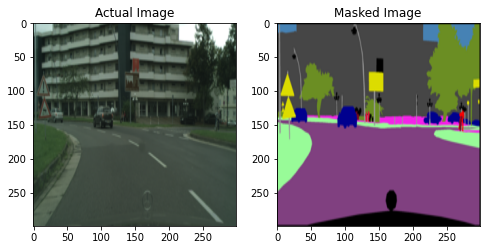

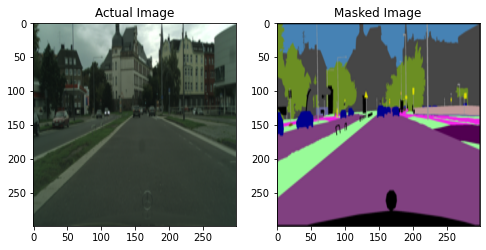

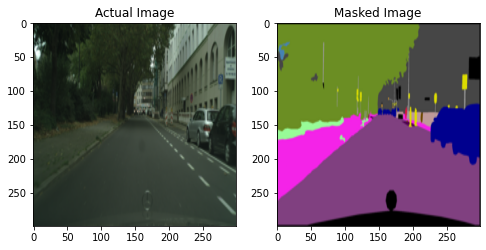

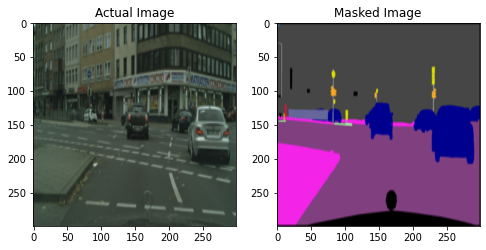

In [ ]:
for img, gt in list(zip(im_train_ds.take(4), gt_train_ds.take(4))):
    visualize_images(img, gt, None)

In [ ]:
import tensorflow
new_model = tensorflow.keras.models.load_model('saved_model/my_model')

# Check its architecture
new_model.summary()

OSError: ignored